OM 501<br>
Vehicle Routing Project Guidelines<br>
DUE DATE: December 4 (wednesday), 2022 @ 6:30pm - 8:30pm.<br>

Description:
The purpose of this team project is to design, construct, and use a Python application that is capable of solving a capacitated vehicle routing problem with multiple demand points and suggesting a distribution strategy for a subset of U.S. states. For the purpose of this project, a distribution strategy specifies: 
- how many distribution centers (DCs) to open, 
- where to open them, 
- the customer assigned to each DC,
- and data insights to support your recommendation.

The data you will be using is based on Home Depot locations in the states of California (CA), Texas (TX), and Alabama (AL). You will be determining solutions for each state.
Problem assumptions are: 
- Home Depot distributes goods to "customer" stores using a single DC and makes weekly shipments.
- Home Depot considers each state separately, i.e., DCs in AL ship only to stores in AL, 
- Demand is given in pounds. Essentially, we are assuming that the products are "heavy", thus, when shipping, we are more constrained by weight rather than volume.
- You have access to vehicles that can haul 40,000 in each trip.

Presentations:
Each team will give a 20 minute presentation detailing their approach to the problem, along with their results for each state and any justification.

In [1]:
import dateutil
import itertools
import json
import pathlib

import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
sns.set_style('whitegrid')

from gurobipy import *
from ipywidgets import interact

## Functions Used

In [2]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    miles = 6367 * c * 0.621371
    return miles

In [3]:
# convert link string to link list to handle saving's key, i.e. str(10, 6) to (10, 6)
def get_node(link):
    link = link[1:]
    link = link[:-1]
    nodes = link.split(',')
    return [int(nodes[0]), int(nodes[1])]

In [4]:
# determine if a node is interior to a route
def interior(node, route):
    try:
        i = route.index(node)
        # adjacent to depot, not interior
        if i == 0 or i == (len(route) - 1):
            label = False
        else:
            label = True
    except:
        label = False
    
    return label

In [5]:
# merge two routes with a connection link
def merge(route0, route1, link):
    if route0.index(link[0]) != (len(route0) - 1):
        route0.reverse()
    
    if route1.index(link[1]) != 0:
        route1.reverse()
        
    return route0 + route1

In [6]:
# sum up to obtain the total passengers belonging to a route
def sum_cap(route):
    sum_cap = 0
    for node in route:
        sum_cap += nodes.demand[node]
    return sum_cap

In [7]:
# sum up to obtain the total miles driven in route
def sum_driver_distance(route):
    sum_driver_distance = nodes.distance_depo[route[0]] + nodes.distance_depo[route[-1]]
    n = 0
    while n < len(route) - 1:
        sum_driver_distance += distance_matrix[route[n]][route[n+1]]
        n += 1
    return sum_driver_distance

In [8]:
# determine 4 things:
# 1. if the link in any route in routes -> determined by if count_in > 0
# 2. if yes, which node is in the route -> returned to node_sel
# 3. if yes, which route is the node belongs to -> returned to route id: i_route
# 4. are both of the nodes in the same route? -> overlap = 1, yes; otherwise, no
def which_route(link, routes):
    # assume nodes are not in any route
    node_sel = list()
    i_route = [-1, -1]
    count_in = 0
    
    for route in routes:
        for node in link:
            try:
                route.index(node)
                i_route[count_in] = routes.index(route)
                node_sel.append(node)
                count_in += 1
            except:
                a = 1
                
    if i_route[0] == i_route[1]:
        overlap = 1
    else:
        overlap = 0
        
    return node_sel, count_in, i_route, overlap

In [9]:
def get_distance_data(df):

    def haversine_np(lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)

        All args must be of equal length.    

        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

        c = 2 * np.arcsin(np.sqrt(a))
        miles = 6367 * c * 0.621371
        return miles


    store_ids = df['store_id'].unique().tolist()
    store_ids_product = list(itertools.product(store_ids, store_ids))
    dm = pd.DataFrame(store_ids_product, columns=['from', 'to'])
    lat_mapper = df.set_index('store_id')['lat'].to_dict()
    lon_mapper = df.set_index('store_id')['lon'].to_dict()
    dm['from_lat'] = dm['from'].map(lat_mapper)
    dm['from_lon'] = dm['from'].map(lon_mapper)
    dm['to_lat'] = dm['to'].map(lat_mapper)
    dm['to_lon'] = dm['to'].map(lon_mapper)
    
    lon1, lat1, lon2, lat2 = map(
        np.radians, 
        [dm['from_lon'], 
        dm['from_lat'], 
        dm['to_lon'], 
        dm['to_lat'],
        ]
    )

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    dm['miles'] = 6367 * c * 0.621371
    
    dm = dm.pivot(
        index='from',
        columns='to',
        values='miles'
    )
    
    return dm

## Clark Wright Model

In [10]:
data_dir = pathlib.Path('data')
data_dir.mkdir(exist_ok=True)

store_data_filepath = pathlib.Path(data_dir, 'stores.csv')

if store_data_filepath.exists():
    store_data = pd.read_csv(store_data_filepath)

store_data.head()

,store_name,state,city,zip,store_id,lat,lon
0,Manchester-Road,MO,Ballwin,63011,3004,38.6091,-90.5598
1,Ellisville,MO,Ellisville,63011,3018,38.6091,-90.5598
2,West-Frederick,MD,Frederick,21702,2511,39.4926,-77.4612
3,I-10-Bullard,LA,New-Orleans,70128,352,30.0487,-89.9585
4,Crystal-River,FL,Crystal-River,34429,6332,28.8547,-82.6669


In [11]:
# create state_df for given state
state = 'TX'
state_df = store_data[store_data['state']==state]
state_df = state_df.reset_index(drop=True)

# Import coordinates for each cluster
if state == 'AL':
    state_cluster = pd.read_csv('Alabama Clusters.csv')
elif state == 'TX':
    state_cluster = pd.read_csv('Texas Clusters.csv')
elif state == 'CA':
    state_cluster = pd.read_csv('California Clusters.csv')
state_df = pd.merge(state_df, state_cluster, how = 'left', left_on = ['lat','lon'], right_on = ['lat','lon'])

coordinates = state_df.set_index('store_id')[['lat', 'lon']].copy()
coordinates = coordinates.reset_index()
#List of Stores For Cluster Running
#store_list = [801, 802, 863, 865]

# get store list for given cluster
store_filter = state_df['Clusters'] == 'Cluster 3'
clusters_stores = state_df.loc[store_filter, :]
store_list = clusters_stores['store_id'].tolist()

In [12]:
# keep store_id, lat, lon
coordinates = coordinates[coordinates['store_id'].isin(store_list)]
coordinates = coordinates.reset_index(drop=True)

demand_data_filepath = pathlib.Path(data_dir, 'demand_data.json')
with open(demand_data_filepath) as fin:
    demand_dict = json.load(fin)

relevant_stores = coordinates['store_id'].tolist()
relevant_demand = {key: val for key, val in demand_dict.items() if int(key) in relevant_stores}
relevant_demand_df = pd.DataFrame().from_dict(relevant_demand, orient='columns')
relevant_demand_df.loc['mean_demand'] = relevant_demand_df.mean()
relevant_demand_df = relevant_demand_df.T['mean_demand']
relevant_demand_df = pd.DataFrame(relevant_demand_df)
relevant_demand_df = relevant_demand_df.reset_index()
store_numbers = relevant_demand_df['index'].tolist()

In [13]:
len(store_numbers)

10

In [14]:
alabama_route_filepath = pathlib.Path('CA_Routes_Cluster5.json')
if alabama_route_filepath.exists():
    with open(alabama_route_filepath) as fin:
        alabama_route_results = json.load(fin)
else:
    alabama_route_results = {}

isFirst = True   # flag changes to False after first iteration
for i in store_numbers:
    depot_location = i
    print(f'Depot location: {depot_location}')
    non_depot_stores = np.setdiff1d(store_numbers,depot_location).tolist()
    total_stores = non_depot_stores
    total_stores.insert(0,depot_location)
    distance_to_depot = coordinates.copy()
    #Determining all stores distance from depot_location[i]
    distance_to_depot['depot_lat'] = distance_to_depot.loc[distance_to_depot['store_id'] == int(depot_location), 'lat'].iloc[0]
    distance_to_depot['depot_lon'] = distance_to_depot.loc[distance_to_depot['store_id'] == int(depot_location), 'lon'].iloc[0]
    distance_to_depot['distance'] = haversine_np(distance_to_depot['depot_lon'], distance_to_depot['depot_lat'], distance_to_depot['lon'], distance_to_depot['lat'])

    #Distance to Depot for sum_driver_distance formula
    nodesdatafarme = pd.DataFrame()
    nodesdatafarme['index'] = distance_to_depot['store_id']
    nodesdatafarme['distance_to_depo'] = distance_to_depot['distance']
    relevant_demand_df['index'] = relevant_demand_df['index'].astype(int)
    nodes = pd.merge(nodesdatafarme, relevant_demand_df, how='left', on='index')
    nodes.columns = ['store_id', 'distance_depo', 'demand']
    nodes = nodes.set_index('store_id')
    #All stores that are not Depot
    locations = coordinates.copy()
    locations = locations[locations['store_id'] != int(total_stores[0])]
    locations = locations.reset_index()
    locations = locations.drop(columns = 'index')
    #Adding 2 hours of stopping time to unload
    distance_matrix = get_distance_data(locations)
    numeric_cols = [col for col in distance_matrix]
    distance_matrix[numeric_cols] += 100
    savings = dict()
    for r in distance_matrix.index:
        for c in distance_matrix.columns:
            if int(c) != int(r):            
                a = max(int(r), int(c))
                b = min(int(r), int(c))
                key = '(' + str(a) + ',' + str(b) + ')'
                savings[key] = nodes['distance_depo'][int(r)] + nodes['distance_depo'][int(c)] - distance_matrix[c][r]

    # determining Clark Wright savings Nodes
    sv = pd.DataFrame.from_dict(savings, orient = 'index')
    sv.rename(columns = {0:'saving'}, inplace = True)
    sv.sort_values(by = ['saving'], ascending = False, inplace = True)


    #### Modeling The Routes Using Clark Wright #####


    # create empty routes
    routes = list()

    # if there is any remaining customer to be served
    remaining = True

    # determine capacity of the vehicle
    cap = 40000
    max_driver_distance = 600   # Extra 100 miles to account for docking time

    # record steps
    step = 0

    # get a list of nodes, excluding the depot
    node_list = list(nodes.index)
    node_list.remove(int(depot_location))

    # run through each link in the saving list
    for link in sv.index:
        step += 1
        if remaining:

            #print('step ', step, ':')

            link = get_node(link)
            node_sel, num_in, i_route, overlap = which_route(link, routes)

            # condition a. Either, neither i nor j have already been assigned to a route, 
            # ...in which case a new route is initiated including both i and j.
            if num_in == 0:
                if sum_cap(link) <= cap and sum_driver_distance(link) <= max_driver_distance:
                    routes.append(link)
                    node_list.remove(link[0])
                    node_list.remove(link[1])
                    #print('\t','Link ', link, ' fulfills criteria a), so it is created as a new route')
                #else:
                    #print('\t','Though Link ', link, ' fulfills criteria a), it exceeds maximum load, so skip this link.')

            # condition b. Or, exactly one of the two nodes (i or j) has already been included 
            # ...in an existing route and that point is not interior to that route 
            # ...(a point is interior to a route if it is not adjacent to the depot D in the order of traversal of nodes), 
            # ...in which case the link (i, j) is added to that same route.    
            elif num_in == 1:
                n_sel = node_sel[0]
                i_rt = i_route[0]
                position = routes[i_rt].index(n_sel)
                link_temp = link.copy()
                link_temp.remove(n_sel)
                node = link_temp[0]

                cond1 = (not interior(n_sel, routes[i_rt]))
                cond2 = (sum_cap(routes[i_rt] + [node]) <= cap and sum_driver_distance(routes[i_rt] + link) <= max_driver_distance)

                if cond1:
                    if cond2:
                        #print('\t','Link ', link, ' fulfills criteria b), so a new node is added to route ', routes[i_rt], '.')
                        if position == 0:
                            routes[i_rt].insert(0, node)
                        else:
                            routes[i_rt].append(node)
                        node_list.remove(node)
                    #else:
                        #print('\t','Though Link ', link, ' fulfills criteria b), it exceeds maximum load, so skip this link.')
                        #continue
                #else:
                    #print('\t','For Link ', link, ', node ', n_sel, ' is interior to route ', routes[i_rt], ', so skip this link')
                    #continue

            # condition c. Or, both i and j have already been included in two different existing routes 
            # ...and neither point is interior to its route, in which case the two routes are merged.        
            else:
                if overlap == 0:
                    cond1 = (not interior(node_sel[0], routes[i_route[0]]))
                    cond2 = (not interior(node_sel[1], routes[i_route[1]]))
                    cond3 = (sum_cap(routes[i_route[0]] + routes[i_route[1]]) <= cap and sum_driver_distance(routes[i_route[0]]) + sum_driver_distance(routes[i_route[1]]) <= max_driver_distance);

                    if cond1 and cond2:
                        if cond3:
                            route_temp = merge(routes[i_route[0]], routes[i_route[1]], node_sel)
                            temp1 = routes[i_route[0]]
                            temp2 = routes[i_route[1]]
                            routes.remove(temp1)
                            routes.remove(temp2)
                            routes.append(route_temp)
                            #node_list.remove(link[0])
                            #node_list.remove(link[1])
                            #print('\t','Link ', link, ' fulfills criteria c), so route ', temp1, ' and route ', temp2, ' are merged')
                        #else:
                            #print('\t','Though Link ', link, ' fulfills criteria c), it exceeds maximum load, so skip this link.')
                            #continue
                    #else:
                        #print('\t','For link ', link, ', Two nodes are found in two different routes, but not all the nodes fulfill interior requirement, so skip this link')
                        #continue
                #else:
                    #print('\t','Link ', link, ' is already included in the routes')
                    #continue

        #     for route in routes: 
        #         print('\t','route: ', route, ' with load ', sum_cap(route))
        #         print('\t','route: ', route, ' with distance ', sum_driver_distance(route))
        # else:
        #     print('-------')
        #     print('All nodes are included in the routes, algorithm closed')
        #     break

        remaining = bool(len(node_list) > 0)

    # check if any node is left, assign to a unique route
    for node_o in node_list:
        routes.append([node_o])

    # add depot to the routes
    total_distance_traveled = 0
    for route in routes:
        total_distance_traveled += sum_driver_distance(route)
        route.insert(0,0)
        route.append(0)

    print('------')
    print(f'Routes found are: {routes}')
    print(f'Depot Location: {depot_location}')
    print(f'Total Distance Traveled: {total_distance_traveled}')

    # if it is the first iteration, set it as best route
    if isFirst == True:
        best_route_dict = {
            'routes': routes,
            'total_distance_traveled': total_distance_traveled,
            'depot_location': depot_location,
        }
        isFirst = False

    # check if current route is better than best route
    print(f"cur = {total_distance_traveled}, best = {best_route_dict['total_distance_traveled']}")
    if total_distance_traveled < best_route_dict['total_distance_traveled']:
        best_route_dict['routes'] = routes
        best_route_dict['total_distance_traveled'] = total_distance_traveled
        best_route_dict['depot_location'] = depot_location

    with open(alabama_route_filepath, 'w') as fout:
        json.dump(best_route_dict, fout)

Depot location: 6807
------
Routes found are: [[0, 6827, 505, 0], [0, 562, 561, 0], [0, 6552, 0], [0, 6831, 0], [0, 8523, 0], [0, 522, 0], [0, 523, 0]]
Depot Location: 6807
Total Distance Traveled: 3895.352451538889
cur = 3895.352451538889, best = 3895.352451538889
Depot location: 561
------
Routes found are: [[0, 8523, 522, 0], [0, 6831, 6552, 0], [0, 6827, 505, 0], [0, 6807, 562, 0], [0, 523, 0]]
Depot Location: 561
Total Distance Traveled: 2301.9268076067533
cur = 2301.9268076067533, best = 3895.352451538889
Depot location: 6552
------
Routes found are: [[0, 562, 561, 0], [0, 6827, 505, 0], [0, 6807, 0], [0, 6831, 0], [0, 8523, 0], [0, 522, 0], [0, 523, 0]]
Depot Location: 6552
Total Distance Traveled: 3552.604210556394
cur = 3552.604210556394, best = 2301.9268076067533
Depot location: 6831
------
Routes found are: [[0, 562, 561, 0], [0, 6552, 6827, 505, 0], [0, 6807, 0], [0, 8523, 0], [0, 522, 0], [0, 523, 0]]
Depot Location: 6831
Total Distance Traveled: 3593.455408860794
cur = 35

## Plot best routes for Alabama

Cluster 1

In [15]:
store_ids = relevant_stores
best_route_dict['depot_location']

'562'

In [16]:
# get coordinates of each store_id
xc = coordinates['lat'].tolist()
yc = coordinates['lon'].tolist()

In [17]:
# make dictionary to look up lat and lon of store_id
coords_dict = {}
    
i = 0
while i < len(store_ids):
    if store_ids[i] == int(best_route_dict['depot_location']):
        coords_dict[0] = [xc[i], yc[i]]
    else:
        coords_dict[store_ids[i]] = [xc[i], yc[i]]
    i+=1

In [18]:
# get active arcs
active_arcs = []
for route in best_route_dict['routes']:
    cur_arc = []
    i = 0
    while i < len(route)-1:
        cur_arc.append((route[i], route[i+1]))
        i += 1
    active_arcs.append(cur_arc)

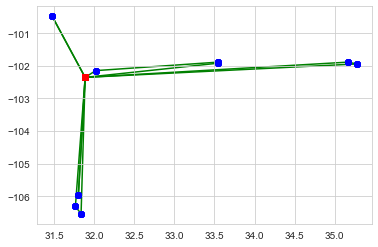

In [19]:
for arc in active_arcs:
    for i, j in arc:
        # i,j: store_ids -------- O,1: x,y coords
        plt.plot([coords_dict[i][0], coords_dict[j][0]], [coords_dict[i][1], coords_dict[j][1]], c='g', zorder=0)
    plt.plot(coords_dict[0][0], coords_dict[0][1], c='r', marker='s')
    plt.scatter(xc[0:], yc[0:], c='b')

Next Steps:
- Add all Alabama clusters
- Repeat process for other states

1. make clark wright a function so we can get arcs for individual clusters in a loop
2. add key in coords_dict to specify which cluster we want arcs from
3. should be able to adjust plot for loop to print all clusters on one graph